In [1]:
import spikeinterface.full as si
from spikeinterface.sorters import get_default_sorter_params, get_sorter_params_description
import probeinterface as pi
from spikeinterface_gui import run_mainwindow
from pathlib import Path
import json
import woodsort
import warnings


In [2]:
# Spike sorting pipeline for the H7100 dataset
# Experimenter: Trisha Narayanan 
# Acquired: Dec 2024 - May 2025

### Parameters set manually ### 

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
#recfolder_path ='/home/avadher/SIDB_Datastore/Trisha/Raw/H7100/H7113/H7113-250604'
recfolder_path = '/home/avadher/Data/H7113-250604/'

# set parameters for probe
shank_groups = [0, 1] # specify which groups in the xml file are shanks to be sorted (0-base)
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# set parameters for spike sorting
sorter = "mountainsort5"
n_jobs = 12  # number of CPU cores to run everything on 
analyzer_metrics_path = 'params/default_analyzer_metrics.json' # list of metrics for Analyzer to compute 

# set parameters for tracking 
ttl_channel = 64 # channel in DAT file where camera TTL pulses are registered (0-base)
column_names=['x_left','y_left','x_right','y_right']  # keep the same names but change order as recorded
pixel_width = 0.1304  # size of one pixel in cm, get from video by typing pixelwidth in terminal 
min_spacing = 3  # minimum spacing between two LEDs in cm 
max_spacing = 8  # maximum spacing between two LEDs in cm 


### parameters set automatically ### 

# Set paths 
recfolder_path = Path(recfolder_path)
analyzer_metrics_path = Path(woodsort.__file__).parent / analyzer_metrics_path
session_name = recfolder_path.name
processed_folder_name = 'Processed'
spikesorting_folder_name = f"{session_name}_sorting_{sorter}"
spikesorting_path =recfolder_path / spikesorting_folder_name
analyzer_folder_name = f"{session_name}_analyzer_{sorter}"
analyzer_path = recfolder_path / analyzer_folder_name
curation_path = analyzer_path / 'spikeinterface_gui/curation_data.json'

# Set the number for cores for parallel processing 
si.set_global_job_kwargs(n_jobs=n_jobs) 

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


metadata = woodsort.helper_functions.get_metadata_openephys(recfolder_path)
print(metadata)



Sync metadata written to: /home/avadher/Data/H7113-250604/MetadataOpenephys.txt
['Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749044772720 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0', 'Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749045560326 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0', 'Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749051166868 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0']


Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping
write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=3.43 MiB - total_memory=41.20 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.186 seconds ***
Running phase 1 sorting
Number of channels: 30
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [  4.5 450. ]
Channel 1: [  6. 600.]
Channel 2: [  2. 200.]
Channel 3: [  7.5 750. ]
Channel 4: [ 0.5 50. ]
Channel 5: [  7. 700.]
Channel 6: [-24.5 475. ]
Channel 7: [-23. 325.]
Channel 8: [-24. 425.]
Channel 9: [-21.5 175. ]
Channel 10: [-25.5 575. ]
Channel 11: [-22. 225.]
Channel 12: [-27. 725.]
Channel 13: [-20.5  75. ]
Channel 14: [-26.5 675. ]
Channel 15

FileNotFoundError: [Errno 2] No such file or directory: 'params/default_analyzer_metrics.json'

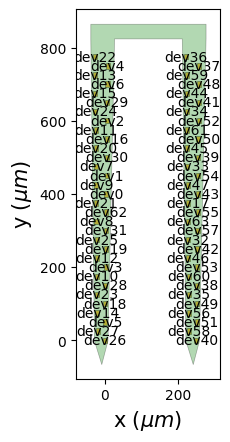

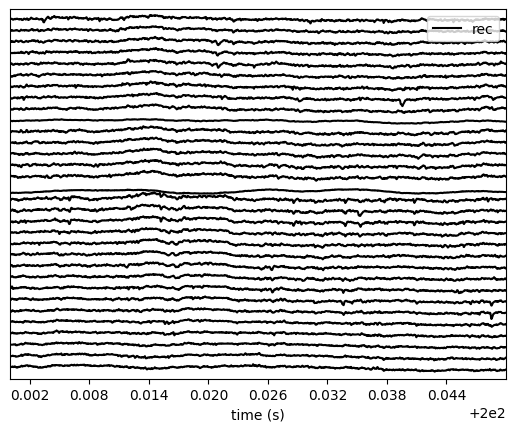

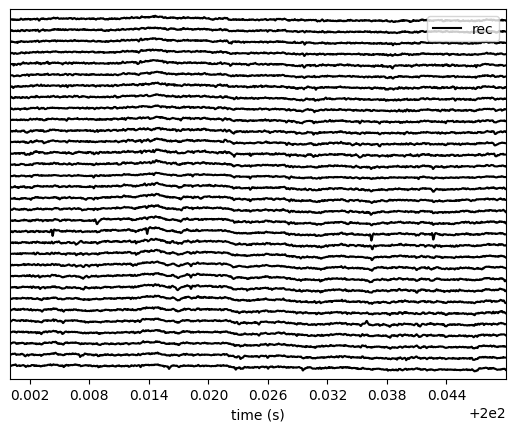

In [4]:
### Spike sorting ### 

# Load recording and probe, preprocess and fill channel indices from Neuroscope
recording = si.read_openephys(recfolder_path,stream_id='0')
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 
recording = woodsort.preprocessing.process_openephys_with_neuroscope(
    recording=recording, 
    probe=probe,
    session_path=recfolder_path,
    shank_groups=shank_groups, 
    plot_probe=True,
    plot_range=[200, 200.05])

# Run spike sorting
sorting = si.run_sorter(
    recording=recording, 
    sorter_name=sorter, 
    remove_existing_folder=True, 
    folder=spikesorting_path)

## Compute analyzer
analyzer_metrics = json.load(open(analyzer_metrics_path))
si.create_sorting_analyzer(
    recording=recording,
    sorting=sorting,
    format="binary_folder",
    folder=analyzer_path,
    overwrite=True,
).compute(analyzer_metrics)



In [4]:
### Manual curation ###

analyzer = si.load_sorting_analyzer(analyzer_path)
run_mainwindow(analyzer, mode="desktop", curation=True)


In [5]:
### Sanity check: apply curation to analyzer

# default curation path
curation_path = analyzer_path / "spikeinterface_gui/curation_data.json"
with open(curation_path, "r") as f:
    curation_dict = json.load(f)

curated_analyzer = si.apply_curation(analyzer, curation_dict, merging_mode='soft')
run_mainwindow(curated_analyzer, mode="desktop", curation=True)

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/3 [00:00<?, ?it/s]


Extracting recording boundaries...
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3

Epoch timestamps saved to: /home/avadher/Data/H7113-250604/EpochTimestamps.csv


Sync metadata written to: /home/avadher/Data/H7113-250604/MetadataOpenephys.txt

Aligning Bonsai tracking data...

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
TTL pulses:         25592
Bonsai frames:      25591
Trimming 1 extra TTL pulses at the end

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
TTL pulses:         216494
Bonsai frames:      216480
Trimming 14 extra TTL pulses at the en

Extracting LFP:  93%|█████████▎| 180/194 [00:25<00:01,  7.05it/s]


KeyboardInterrupt: 

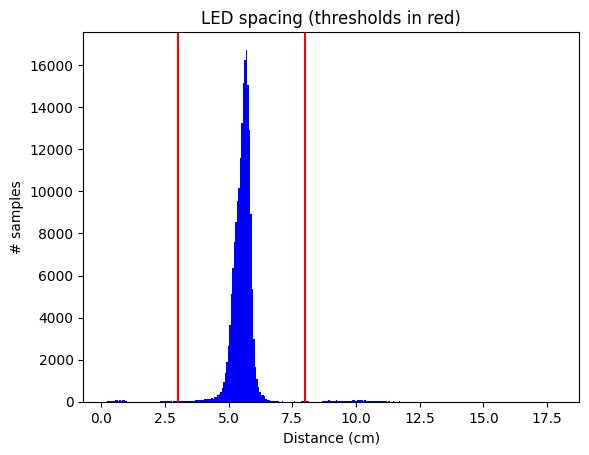

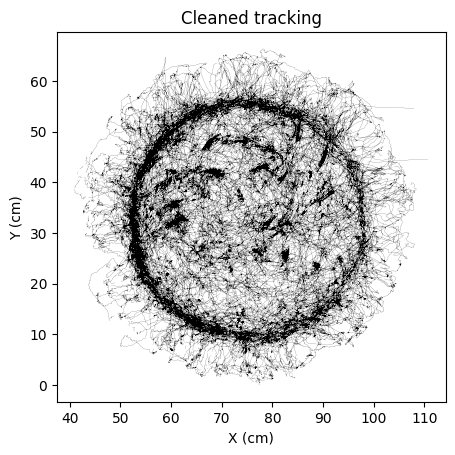

In [6]:
### Get other data from the recording ###

# get epochs
epochs = woodsort.helper_functions.get_epochs_openephys(
    recfolder_path, 
    save_path =recfolder_path)

# get OpenEphys metadata
woodsort.helper_functions.get_metadata_openephys(
        recfolder_path, 
        save_path =recfolder_path)

# align tracking
aligned_tracking = woodsort.tracking.align_tracking_bonsai(
    recfolder_path=recfolder_path, 
    ttl_channel=ttl_channel, 
    column_names=column_names, 
    save_path=recfolder_path)

# process tracking
processed_tracking = woodsort.tracking.process_tracking_bonsai(
        aligned_tracking,   
        pixel_width=pixel_width,      # conversion factor: cm per pixel
        min_spacing=min_spacing,      # minimum allowed LED spacing (cm)
        max_spacing=max_spacing,  
        save_path=recfolder_path,  # maximum allowed LED spacing (cm)
        plot=True)             # whether to show diagnostic plot

# Extract LFP
woodsort.lfp.extract_lfp_openephys(recfolder_path)


Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping
Device channel indices before adding to the recording
[22  4 13  6 15 29 24  2 11 16 20 30  7  1  9  0 21 62  8 31 25 19 12  3
 10 28 23 18 14  5 27 26 36 37 59 48 44 41 34 52 61 50 45 39 33 54 47 43
 17 55 63 57 32 42 46 53 60 38 35 49 56 51 58 40]
Device channel indices after adding to the recording
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Device channel indices before splitting by group
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Device channel indices after splitting by group
[ 0

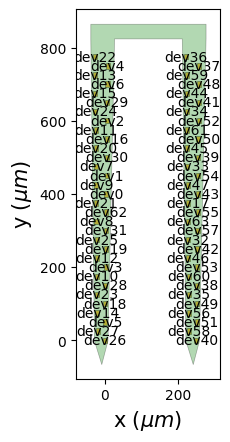

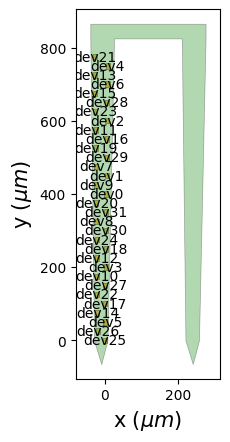

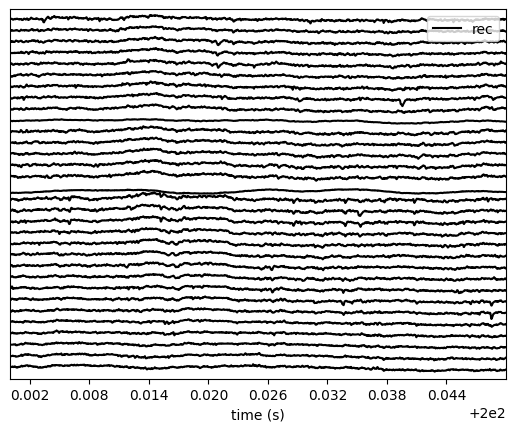

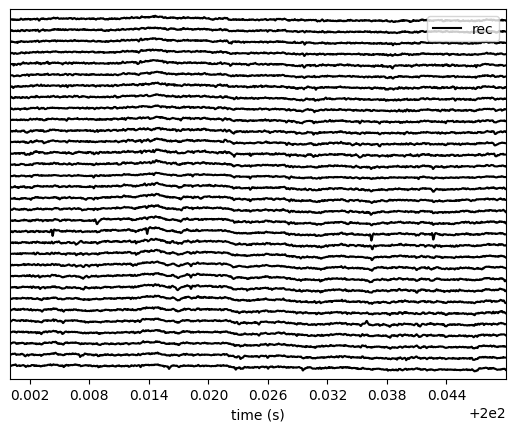

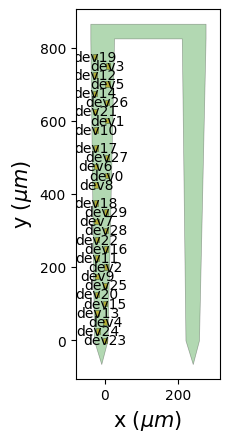

In [3]:
# Load recording and probe, preprocess and fill channel indices from Neuroscope
recording = si.read_openephys(recfolder_path,stream_id='0')
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 
recording = woodsort.preprocessing.process_openephys_with_neuroscope(
    recording=recording, 
    probe=probe,
    session_path=recfolder_path,
    shank_groups=shank_groups, 
    plot_probe=True,
    plot_range=[200, 200.05])